# Nordcloud Machine Learning Engineer recruitment excercise solution
This repository contains an attempt at solving the Nordcloud Machine Learning recruitment task. The description of the task was provided as specified in the following sections. This repository contains both the CSV file with prediction results for the test dataset (unseen data), as well as a Jupyter Notebook where the full code and a detailed description of the reasoning is provided.  

## Problem Statement
During this phase of the recruitment process, your task is to use the digital marketing campaign to log
level data in order to score entries according to their likelihood of being attributed as a click event.
You will be evaluated on your ability to predict click events and also to explain the rationale behind
your methodology: the methods used and the extracted relevant output.

## Data Description

A dataset with 463.291 entries from a 2021 online advertising campaign is provided.
The training set pertains to the time period of 9.04.2021 - 12.04.2021, while the test set only
contains the day of 14.04.2021.

The training set consists of the following attributes:

1. **Session Id** – refers to session identifier
2. **DateTime** – refers to date and time of the entry
3. **User Id** – refers to the user identifier
4. **Product Type** – refers to the product type
5. **Campaign Id** – refers to the campaign identifier
6. **Webpage Id** - refers to the webpage identifier
7. **Product Category** – refers to the product category
8. **Advertisement Size** – refers to the advertisement size
9. **User Depth** - refers to user’s duration of exposure to the advertisement during the respective entry (`3` being the longest, `1` being the shortest and `NA` being the inability to measure the time spent)
10. **Internet Browser Id** – refers to the identifier of the Internet browser type and version
11. **Gender** – refers to the gender
12. **Age Group** – refers to the age group
13. **City Size** – refers to the city size
14. **Device Used** – refers to the device used (could be Mobile or PC/Laptop)
15. **Clicked** – refers to the fact that the user clicked on the advertisement
16. **Interested in Cars** - refers to the fact that the person is interested in cars

17. **Interested in Food** - refers to the fact that the person is interested in food
18. **Interested in News** - refers to the fact that the person is interested in news
19. **Interested in Technology** - refers to the fact that the person is interested in technology
20. **Interested in Medicine** - refers to the fact that the person is interested in Medicine
21. **Interested in Politics** - refers to the fact that the person is interested in Politics
22. **Interested in Fashion** - refers to the fact that the person is interested in fashion
23. **Interested in Astronomy** - refers to the fact that the person is interested in Astronomy
24. **Interested in Animals** - refers to the fact that the person is interested in animals
25. **Interested in Travel** - refers to the fact that the person is interested in travelling

## Scoring and Evaluation
In order to be evaluated for this task, please send your solution as a `.py` or a `.ipynb` file and also a
`.csv` file with two columns: `Session Id` and `Clicked`. The first column in the ensuing `.csv` file
should match the column of the same name in the submission file provided. We will use these
identifiers to match your entries to the reference ones. The identifiers should be the same as those
used in the original file. Additionally, in the event of a smaller number of rows than in the original file,
the score will be 0.
The second column should be a numeric column consisting of float values between 0 and 1, which
represent the probabilities of successful click events. The aforementioned being valued as follows: `1`
meaning that the entry will definitely have a click attributed to it, while `0` meaning there is no chance
of a click happening.


# Solution
Solving the problem as stated above requires building a logistic regression model (a binary classifier) for ad click prediction based on a training dataset which contains a set of features and a target class (`Clicked`), which means that this is a supervised learning task.

## Plan
- **Explore the dataset.** We first need to do some easy exploratory analysis in order to learn some basic facts about the provided data. This includes looking into the formats in which the specific information (future features) are presented, search for missing values, check for target class leaks (through strong correlations between features), etc.

- **Preprocess the data**. Once we get to know the dataset we should conduct some basic preprocessing. This might include handling (populating?) the missing data, reformatting existing values to better fit our purpose, etc. E.g.: convert floats to categorical values (ints - use the so-called one-hot encoding), parse datetetime strings and extract their meaningful parts, etc.

- **Engineer more features**. If we parse the datetime fields and extract their hour-, minute- and day-of-week-parts this would in fact mean that we are adding new features based on the old ones, i.e. engineering new features. Such new features might help train a better model but there is of course a price that have to pay - the size of the resulting input feature vector and the possibly huge number of model parameters -- depending on the modelling paradigm that we choose.

- **Handle dataset category imbalance**. If it turns out (and it indeed does turn out) that the dataset is imbalanced - we need to address this issue. Otherwise, in case of severe imbalance, the model (regardless of the modelling method and model class that we choose) will favor the dominating category. This is a difficult problem and although a number of techniques exist it was never fully solved. The solution we eventually apply depends on many circumstances and should result from all of the previous steps (such as the exploratory analysis of the dataset) as well as from the final choice of the modelling method and an iterative model refinement and evaluation process.

- **Choose a classification model**. Although there are some immediate candidates for the modelling technique to use for the current problem - such as the Random Forest Classifier or the XGBoost-based classifier, the final choice should be based on an iterative process of model evaluation. The evaluation method should address all standard issues, such as model overfitting.

- **Predict categories for the test dataset**. Using the resulting modelling pipeline we should predict binary labels for the provided test dataset which comprise the final solution for the current modelling task.


# Implementation

First, we import all necessary libraries. We will be using the standard tools in the Python data science/ML ecosystem.

**Pandas** for data ingestion and transformation as it allows for better readability and easier manipulation than the bare **numpy** which we also use here sporadically as no advanced array manipulations are required. It also became the de facto standard for Python-based data science.

**Matplotlib** and **Seaborn** for data plotting. Matplotlib has also become a standard and it underlies most other modelling libraries such as pandas. Seaborn gives us even more tools and some useful shorthands for some of the useful plot types.

Since, as we will see further, there is no point in implementing Deep Neural Networks for the current task (although they could also perform well - especially the CNN or some form of a Temporal Convolutional Network if we turn the problem into a sequence modelling task), we will be using the standard Machine Learning library **SciKit-Learn** which provides all of the necessary tools to build a full ML pipeline.

We use **XGBoost** as this is one of the modelling approaches the we will be evaluating (and might even end up using it as the final solution :)).

**ImbLearn** is a library that provides a set of tools for handling imbalanced datasets (mainly up- and down-sampling techniques).

In [1]:
import math
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

We change the number of columns that pandas prints out by default as we want to see the whole of the records. We keep the default maximum number of rows in order to save resources as the dataset is too large for printing in its entiriety.

In [2]:
pd.set_option('display.max_columns', None)

We define some handy *constants*.

In [3]:
DATA_DIR = "./data"
TRAINSET_FILENAME = "train_set.csv"
TESTSET_FILENAME = "test_set.csv"

We are now ready to read in the csv data and see what is in there.

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, TRAINSET_FILENAME))
test_df = pd.read_csv(os.path.join(DATA_DIR, TESTSET_FILENAME))

In [5]:
train_df

,Session Id,DateTime,User Id,Product Type,Campaign Id,Webpage Id,Product Category,Advertisment Size,User Depth,Internet Browser Id,Gender,Age Group,City Size,Device Used,Clicked,Interested In Cars,Interested In Food,Interested In News,Interested In Technology,Interested In Medicine,Interested In Politics,Interested In Fashion,Interested In Astronomy,Interested In Animals,Interested In Travel
0,229ac4c2-0ee9-4a3b-b52c-3b20c9d43039,09-04-2021 00:00,858557,C,359520,13787,4,NaN,3.0,10.0,F,45-54,5900000.0,Mobile,No,1,0,1,0,1,0,0,0,1,0
1,87c0f74a-fa7a-4b3f-bc48-ad1a5f80de2e,09-04-2021 00:00,243253,C,105960,11085,5,NaN,2.0,8.0,F,25-34,NaN,Mobile,No,1,0,1,1,1,0,0,0,1,1
2,b746f0ad-1aa3-492c-b7fa-5dd95643fb51,09-04-2021 00:00,243253,C,359520,13787,4,NaN,2.0,8.0,F,25-34,NaN,Mobile,No,1,0,0,1,0,0,1,0,0,0
3,36257832-77d5-4d8d-9abd-25d49dffb20d,09-04-2021 00:00,1097446,I,359520,13787,3,NaN,3.0,3.0,M,35-44,500000.0,PC/Laptop,No,0,1,1,1,0,0,1,0,0,0
4,df3a66aa-4714-407d-b6fe-49fe03ce8f16,09-04-2021 00:01,663656,C,405490,60305,3,NaN,3.0,2.0,M,25-34,500000.0,PC/Laptop,No,0,1,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391820,0bf0e766-b3af-4204-8635-ce842a9bf5de,13-04-2021 23:59,1051210,I,118601,28529,4,82527.0,2.0,3.0,M,35-44,NaN,PC/Laptop,No,1,0,1,0,0,1,0,1,0,1
391821,8ea4b3e8-8021-4246-a2dd-aa0696eefedc,13-04-2021 23:59,922338,H,118601,28529,5,82527.0,3.0,5.0,M,55-64,NaN,PC/Laptop,No,1,0,1,0,0,1,0,1,0,1
391822,e27e54ff-535b-4bdc-8289-7127ed61c88f,13-04-2021 23:59,922338,H,118601,28529,5,82527.0,3.0,5.0,M,55-64,NaN,PC/Laptop,No,1,0,0,0,0,0,0,1,1,0
391823,3c205416-37ed-4652-8caa-cb92a11d560a,13-04-2021 23:59,246766,C,360936,13787,5,NaN,3.0,1.0,M,18-24,NaN,Mobile,No,1,1,0,1,1,1,0,0,1,1


Let's parse the dates first.

In [6]:
def parse_dates(df):
    df["DateTime"] = pd.to_datetime(
        df["DateTime"],
        format = "%d-%m-%Y %H:%M",
        errors = "coerce"
    )

In [7]:
parse_dates(train_df)
parse_dates(test_df)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391825 entries, 0 to 391824
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Session Id                391825 non-null  object        
 1   DateTime                  391825 non-null  datetime64[ns]
 2   User Id                   391825 non-null  int64         
 3   Product Type              391825 non-null  object        
 4   Campaign Id               391825 non-null  int64         
 5   Webpage Id                391825 non-null  int64         
 6   Product Category          391825 non-null  int64         
 7   Advertisment Size         70234 non-null   float64       
 8   User Depth                376082 non-null  float64       
 9   Internet Browser Id       376082 non-null  float64       
 10  Gender                    376082 non-null  object        
 11  Age Group                 376082 non-null  object        
 12  Ci

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71466 entries, 0 to 71465
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Session Id                71466 non-null  object        
 1   DateTime                  71466 non-null  datetime64[ns]
 2   User Id                   71466 non-null  int64         
 3   Product Type              71466 non-null  object        
 4   Campaign Id               71466 non-null  int64         
 5   Webpage Id                71466 non-null  int64         
 6   Product Category          71466 non-null  int64         
 7   Advertisment Size         27203 non-null  float64       
 8   User Depth                68966 non-null  float64       
 9   Internet Browser Id       68966 non-null  float64       
 10  Gender                    68966 non-null  object        
 11  Age Group                 68966 non-null  object        
 12  City Size         

After an initial glimpse at the data we find out a number of things:

First of all we see that some of the columns will surely need further processing. The `DateTime` field needs to be turned into some form of a meaningful datetime information. Some other categorical columns like the `Product Type` or the `Age Group` need to be turned into a format that will be better *understood* by our model of choice. Also we notice some missing values (appearing as `NaN`). The last few columns seem to be already one-hot encoded which is nice. Also the target category `Clicked` should probably be mapped into the more standard `1`-`0` values.

We should also inspect some of the provided information, such as the `User Id` column and see if they can be of some use to us or should be dropped from the dataset altogether.

Here, we check the target class and see if the dataset is by any chance balanced (it's not).

In [10]:
train_df.value_counts("Clicked")

Clicked
No     364895
Yes     26930
dtype: int64

First, we see how many missing values we have. It seems from the below plot that there is too many of them to simply drop the records that contain `NaN`s. We should come up with some way to handle or fill the missing values.

In [11]:
print(train_df.isnull().sum())

Session Id                       0
DateTime                         0
User Id                          0
Product Type                     0
Campaign Id                      0
Webpage Id                       0
Product Category                 0
Advertisment Size           321591
User Depth                   15743
Internet Browser Id          15743
Gender                       15743
Age Group                    15743
City Size                   107129
Device Used                      0
Clicked                          0
Interested In Cars               0
Interested In Food               0
Interested In News               0
Interested In Technology         0
Interested In Medicine           0
Interested In Politics           0
Interested In Fashion            0
Interested In Astronomy          0
Interested In Animals            0
Interested In Travel             0
dtype: int64


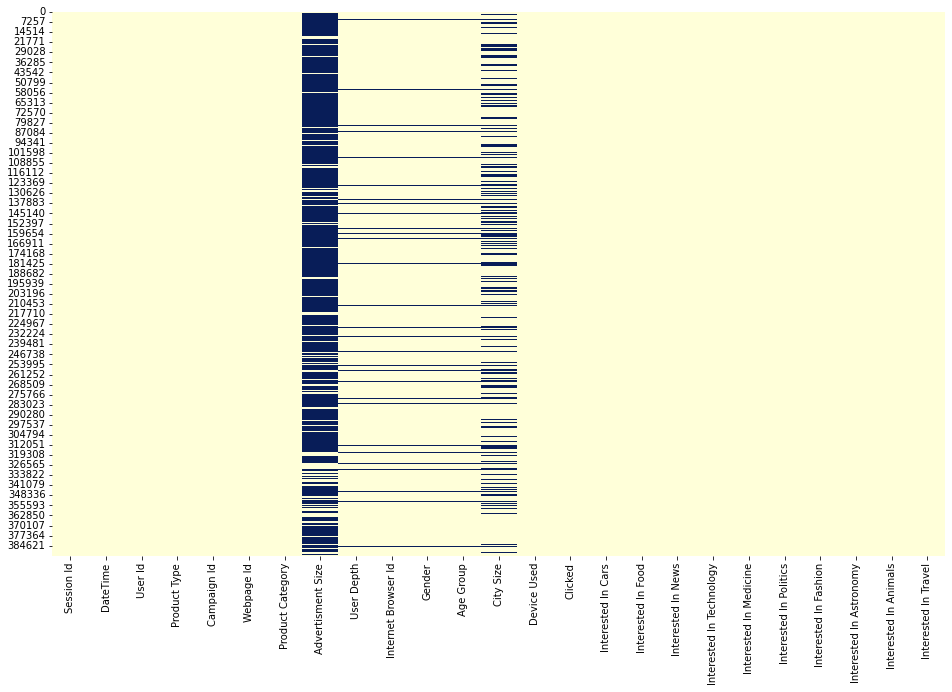

In [12]:
plt.figure(figsize=(16,10))
sns.heatmap(train_df.isnull(), cbar=False, cmap="YlGnBu")
plt.show()

Looking at the `User Id` column it seems that we not only have numerous records for some users in the train dataset but they also reappear in the test set. This means that we should try and use this information as a feature.

In [13]:
train_df.value_counts("User Id")

User Id
658554    232
297960    191
983136    160
422201    150
929999    135
         ... 
559973      1
559972      1
110646      1
559957      1
4           1
Length: 135659, dtype: int64

In [14]:
test_df.value_counts("User Id")

User Id
678048     65
577452     48
246571     39
728477     37
378888     37
           ..
427932      1
427815      1
427806      1
427659      1
1141716     1
Length: 38590, dtype: int64

In [15]:
intersecting_user_ids = ((len(set(test_df["User Id"].unique()).intersection(set(test_df["User Id"].unique())))) / (train_df["User Id"].unique().shape[0] + test_df["User Id"].unique().shape[0])) * 100
print(f"The percent of intersecting user ids in both datasets: {round(intersecting_user_ids, 2)}%")

The percent of intersecting user ids in both datasets: 22.15%


Although there are some missing values in the age groups they should be rather easy to encode using the one-hot scheme - this would also be a good way to account for the missing values as these would be hard to fill otherwise.

In [16]:
train_df["Age Group"].value_counts(dropna=False)

35-44    135106
25-34    121770
45-54     53325
18-24     37143
55-64     26252
NaN       15743
>65        2353
<18         133
Name: Age Group, dtype: int64

Check some of the other features. See if there are log entries that correspond to that same session id, check if the sets of Webpage Ids are very different in both datasets.

In [17]:
train_df["Advertisment Size"].value_counts(dropna=False).sort_index()

18595.0         59
32026.0        402
66101.0         34
82527.0      17695
99226.0          2
143597.0      2279
146115.0     22003
168114.0         2
181650.0         1
202351.0         1
234846.0        24
235358.0        14
247789.0         1
254132.0     10978
255689.0        55
269093.0       745
270147.0         1
270915.0     15767
300711.0         4
301147.0         1
327439.0         6
372532.0        41
381435.0         1
408790.0        53
408831.0        12
419304.0         1
419804.0        37
447834.0         2
450184.0        13
NaN         321591
Name: Advertisment Size, dtype: int64

In [18]:
test_df["Advertisment Size"].value_counts(dropna=False).sort_index()

18595.0        17
32026.0       176
82527.0     17836
143597.0      422
146115.0     3221
234846.0        1
235358.0        5
254132.0     1524
255689.0        7
269093.0      113
270915.0     3857
327439.0        2
408790.0       14
419804.0        6
447834.0        1
450184.0        1
NaN         44263
Name: Advertisment Size, dtype: int64

In [19]:
train_df.shape[0] == train_df["Session Id"].value_counts().shape[0]

True

In [20]:
train_df["Webpage Id"].value_counts()

13787    140510
60305     87450
6970      29383
45962     26042
53587     24816
1734      23943
51181     22417
11085     19569
28529     17695
Name: Webpage Id, dtype: int64

In [21]:
set(test_df["Webpage Id"].value_counts().index.values.tolist()).difference(set(train_df["Webpage Id"].value_counts().index.values.tolist()))

set()

In [22]:
set(train_df["Webpage Id"].value_counts().index.values.tolist()).difference(set(test_df["Webpage Id"].value_counts().index.values.tolist()))

set()

In [23]:
train_df["Campaign Id"].value_counts()

359520    92769
405490    87450
360936    47741
98970     29383
414149    26042
404347    24816
82320     23943
396664    22417
105960    19569
118601    17695
Name: Campaign Id, dtype: int64

Finally we want to check if there's any strong correlation between the features and/or the target category. We use Pearson correlation as it will simply skip the categorical columns for which it does not make any sense to calculate the correlation. We do not observe any bothering/interesting correlations. There's only an expected correlation between the id of the webpage and the campaign.

In [24]:
feat_corr = train_df.corr(method="pearson")

In [25]:
feat_corr.style.background_gradient(cmap='coolwarm')

,User Id,Campaign Id,Webpage Id,Product Category,Advertisment Size,User Depth,Internet Browser Id,City Size,Interested In Cars,Interested In Food,Interested In News,Interested In Technology,Interested In Medicine,Interested In Politics,Interested In Fashion,Interested In Astronomy,Interested In Animals,Interested In Travel
User Id,1.000000,-0.008990,-0.021974,0.031896,0.017148,-0.011783,0.043505,-0.014465,-0.003439,-0.002065,0.001227,0.000528,0.000034,-0.001160,-0.000398,-0.001487,0.000261,0.001492
Campaign Id,-0.008990,1.000000,0.624930,-0.055111,0.153392,-0.018247,-0.030263,0.012489,0.000661,0.002123,-0.003212,0.000597,0.000636,-0.003783,-0.002376,-0.000442,-0.000966,0.000121
Webpage Id,-0.021974,0.624930,1.000000,-0.276826,-0.146802,0.011891,-0.085586,-0.035467,0.000597,0.001306,0.000480,0.001810,0.000718,-0.000869,-0.002098,0.000329,-0.001094,0.001101
Product Category,0.031896,-0.055111,-0.276826,1.000000,0.222473,0.000121,0.094059,0.036862,0.000193,-0.000797,-0.000557,-0.001000,-0.002933,0.002087,-0.003012,-0.001029,0.001821,-0.001553
Advertisment Size,0.017148,0.153392,-0.146802,0.222473,1.000000,-0.064211,0.180085,0.123014,0.000381,0.001717,0.000099,0.004839,-0.003820,-0.002265,-0.003852,0.004766,-0.004189,0.000411
User Depth,-0.011783,-0.018247,0.011891,0.000121,-0.064211,1.000000,-0.012364,-0.056252,0.000015,0.002061,0.000408,-0.000013,0.001262,0.001458,0.002285,0.001437,0.002324,-0.001104
Internet Browser Id,0.043505,-0.030263,-0.085586,0.094059,0.180085,-0.012364,1.000000,0.052685,0.000380,-0.000201,0.000190,-0.000666,-0.002087,-0.002150,0.000237,-0.000126,0.001235,-0.001066
City Size,-0.014465,0.012489,-0.035467,0.036862,0.123014,-0.056252,0.052685,1.000000,0.001850,-0.001609,-0.001551,-0.000805,-0.002169,0.000135,-0.001636,0.002015,-0.002135,0.001262
Interested In Cars,-0.003439,0.000661,0.000597,0.000193,0.000381,0.000015,0.000380,0.001850,1.000000,-0.001120,-0.005051,0.001075,-0.000584,-0.001881,0.001222,0.003678,0.000156,-0.000242
Interested In Food,-0.002065,0.002123,0.001306,-0.000797,0.001717,0.002061,-0.000201,-0.001609,-0.001120,1.000000,0.000647,0.000582,-0.003810,-0.000387,-0.000697,0.000774,0.000806,0.001225


We proceed to implement our data preprocessing function below.

We parse the datetime column into three separate columns denoting the hour, minute and day of week. We skip the month and year because they are meaningless given the size of the provided dataset.

We use one-hot encoding for information in columns `Gender`, `Age Group`, `Device Used` (which becomes `On Mobile`), `Product Category`, `Product Type`, `Internet Browser Id` and `User Depth`.

We also count the min/max range for the continuous values in `City Size` and `Advertisement Size`, define a number of bins and use these to one-hot encode them into separate feature columns. It might have been simpler to just use a single column with a min-max-scaled float value but at this point we did not yet know what modelling method we would be using and given the tolerable size of the feature vector and the numerous missing values in these columns we decided to go with one-hot encoding.

We drop the `Session Id`, `User Id`, `Campaign Id` and `Webpage Id` columns as they seem too specific and we want the model to be more general. We might readd them later depending on preliminary results.

We want, however, to use the `User Id` field to calculate the number of clicks that appeared before any record.

The function could have been refactored and some of the repeated code could have been taken out to helper functions but we skipped this for now to save time and focus on the problem itself.

Using the `Clicked` column we can also engineer new features - such as the click history for each user. This does not include the current click and only the count of the past clicks. This means that we are not leaking the target class into the training data.

In [26]:
def _add_previous_click_count(row, ref_data):
    return ref_data["Clicked"].loc[(ref_data.index.get_level_values('User Id') == row["User Id"]) & (ref_data.index.get_level_values('DateTime') < row["DateTime"])].groupby("DateTime").max().sum()

In [27]:
def add_previous_click_counts(target_data, ref_data):
    ref_data = ref_data.copy().set_index(["User Id", "DateTime"])
    ref_data["Clicked"] = ref_data["Clicked"].str.lower().map(dict(yes=1, no=0)).astype(int)
    target_data["previous_click_count"] = target_data.apply(_add_previous_click_count, axis=1, args=[ref_data])
    
    return target_data

In [28]:
def preprocess_data(data, ref_df, drop_columns=["Session Id", "User Id"]):
    processed_data = data.copy().sort_values("DateTime")
    
    processed_data = add_previous_click_counts(processed_data, ref_df)

    processed_data["DateTime"] = pd.to_datetime(
        data["DateTime"],
        format = "%d-%m-%Y %H:%M",
        errors = "coerce"
    )
    processed_data["hour"] = processed_data["DateTime"].dt.hour / 24
    processed_data["minute"] = processed_data["DateTime"].dt.minute / 60
    processed_data["day_of_week"] = processed_data["DateTime"].dt.dayofweek / 7
    processed_data.drop("DateTime", axis=1, inplace=True)
    
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Gender'], prefix='Gender')], axis=1)
    processed_data.drop("Gender", axis=1, inplace=True)

    # Using one-hot encoding mainly due to NaNs in column. Otherwise a simple normalized float label would be good as there's quantitative/qualitative relation between categories.
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Age Group'], prefix='Age Group')], axis=1)
    processed_data.drop("Age Group", axis=1, inplace=True)
    
    processed_data['On Mobile'] = processed_data['Device Used'].str.lower().map({"pc/laptop": 0, "mobile": 1}).astype(int)
    processed_data.drop("Device Used", axis=1, inplace=True)
    
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Product Category'], prefix='Product_Category')], axis=1)
    processed_data.drop("Product Category", axis=1, inplace=True)

    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Product Type'], prefix='Product_Type')], axis=1)
    processed_data.drop("Product Type", axis=1, inplace=True)

    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Webpage Id'], prefix='Webpage_Id')], axis=1)
    processed_data.drop("Webpage Id", axis=1, inplace=True)
    
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Campaign Id'], prefix='Campaign_Id')], axis=1)
    processed_data.drop("Campaign Id", axis=1, inplace=True)
    
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['Internet Browser Id'], prefix='Internet_Browser_Id')], axis=1)
    processed_data.drop("Internet Browser Id", axis=1, inplace=True)
    
    processed_data = pd.concat([processed_data, pd.get_dummies(processed_data['User Depth'], prefix='User Depth')], axis=1)
    processed_data.drop("User Depth", axis=1, inplace=True)

    city_sizes = sorted(processed_data["City Size"].value_counts().index.values.tolist())
    city_sizes = [0, *city_sizes]
    city_sizes_intervals = [(city_sizes[index], city_sizes[index + 1]) for index in range(len(city_sizes) - 1)]
    # includes the left edge and does not include the right edge
    bins = pd.IntervalIndex.from_tuples(city_sizes_intervals)
    processed_data = pd.concat([
        processed_data,
        pd.get_dummies(
            pd.cut(processed_data["City Size"],
            bins=bins
            ),
        prefix='City Size'
        )
    ], axis=1)
    processed_data.drop("City Size", axis=1, inplace=True)
    
    ad_sizes = train_df["Advertisment Size"].value_counts(dropna=False).sort_index().index.values.tolist()
    ad_sizes = sorted(list(set([math.floor(size / 100000)*100000 for size in ad_sizes if not math.isnan(size)])))
    ad_sizes_intervals = [(ad_sizes[index], ad_sizes[index + 1]) for index in range(len(ad_sizes) - 1)]
    # includes the left edge and does not include the right edge
    bins = pd.IntervalIndex.from_tuples(ad_sizes_intervals)
    processed_data = pd.concat([
        processed_data,
        pd.get_dummies(
            pd.cut(processed_data["Advertisment Size"],
            bins=bins
            ),
        prefix='Advertisment Size'
        )
    ], axis=1)
    processed_data.drop("Advertisment Size", axis=1, inplace=True)
    if "Clicked" in processed_data.columns:
        processed_data["Clicked"] = processed_data["Clicked"].str.lower().map(dict(yes=1, no=0)).astype(int)
    
    processed_data.drop(drop_columns, axis=1, inplace=True)
    
    processed_data = processed_data.rename(columns=lambda col: re.sub('[\[\]\(\)]', '', col.strip().lower()))
    processed_data = processed_data.rename(columns=lambda col: re.sub('\,', '_', col.strip().lower()))
    processed_data = processed_data.rename(columns=lambda col: re.sub('>', 'gt', col.strip().lower()))
    processed_data = processed_data.rename(columns=lambda col: re.sub('<', 'lt', col.strip().lower()))

    
    return processed_data

Lets see how the function works. We can see that only the clicks that appeared BEFORE the current records datetime are counted so we are not leaking any target class info into the training data. We can, however, safely assume that in a real life implementation scenario the model would learn on past user behaviour - hence the engineered feature.

In [29]:
_ref = train_df[train_df["User Id"] == 658554]
_ref[_ref["Clicked"] == "Yes"]

,Session Id,DateTime,User Id,Product Type,Campaign Id,Webpage Id,Product Category,Advertisment Size,User Depth,Internet Browser Id,Gender,Age Group,City Size,Device Used,Clicked,Interested In Cars,Interested In Food,Interested In News,Interested In Technology,Interested In Medicine,Interested In Politics,Interested In Fashion,Interested In Astronomy,Interested In Animals,Interested In Travel
31849,3f98ae77-bcd3-4762-82aa-65fa860df44c,2021-04-09 12:09:00,658554,I,414149,45962,3,NaN,2.0,4.0,M,45-54,NaN,Mobile,Yes,1,1,0,0,0,0,0,1,0,1
31950,74b772a8-9560-43fb-ab2f-a65053804903,2021-04-09 12:10:00,658554,I,404347,53587,1,146115.0,2.0,4.0,M,45-54,NaN,Mobile,Yes,1,1,1,0,1,0,0,1,0,0
106306,986a27a2-631a-4126-b398-834c611611b4,2021-04-10 10:00:00,658554,B,414149,45962,3,NaN,2.0,4.0,M,45-54,NaN,Mobile,Yes,1,1,1,1,0,1,0,0,1,0


In [30]:
train_df_processed = preprocess_data(train_df[train_df["User Id"] == 658554], train_df)

This is how the resulting feature vector list looks like. All features are one-hot encoded or scaled to have values between 0 and 1.

In [31]:
train_df_processed.head(30)

,clicked,interested in cars,interested in food,interested in news,interested in technology,interested in medicine,interested in politics,interested in fashion,interested in astronomy,interested in animals,interested in travel,previous_click_count,hour,minute,day_of_week,gender_m,age group_45-54,on mobile,product_category_1,product_category_2,product_category_3,product_category_4,product_category_5,product_type_b,product_type_d,product_type_e,product_type_f,product_type_g,product_type_h,product_type_i,webpage_id_1734,webpage_id_6970,webpage_id_11085,webpage_id_13787,webpage_id_45962,webpage_id_53587,webpage_id_60305,campaign_id_82320,campaign_id_98970,campaign_id_105960,campaign_id_359520,campaign_id_360936,campaign_id_404347,campaign_id_405490,campaign_id_414149,internet_browser_id_4.0,user depth_2.0,advertisment size_0_ 100000,advertisment size_100000_ 200000,advertisment size_200000_ 300000,advertisment size_300000_ 400000
6720,0,1,0,0,1,1,0,0,0,1,0,0,0.25,0.200000,0.571429,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
6721,0,1,0,1,0,1,0,1,1,1,1,0,0.25,0.200000,0.571429,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0
6747,0,0,0,1,1,1,0,1,0,1,0,0,0.25,0.216667,0.571429,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0
6748,0,0,0,0,1,0,0,0,0,1,0,0,0.25,0.216667,0.571429,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
6750,0,1,1,0,1,1,1,0,0,0,1,0,0.25,0.216667,0.571429,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0
6804,0,1,1,0,0,1,1,1,1,1,0,0,0.25,0.233333,0.571429,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0
6805,0,0,1,0,0,0,1,1,1,0,0,0,0.25,0.233333,0.571429,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
6806,0,1,1,0,1,1,0,0,1,0,0,0,0.25,0.233333,0.571429,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
6872,0,0,0,0,1,0,1,1,0,0,0,0,0.25,0.250000,0.571429,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0
6874,0,0,0,1,1,0,0,1,1,1,1,0,0.25,0.250000,0.571429,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0


In [32]:
train_df[train_df["Clicked"] == "Yes"].groupby("User Id").size().sort_values()

User Id
96         1
679699     1
679615     1
679578     1
679504     1
          ..
394410    10
40010     10
222506    12
357044    13
252158    15
Length: 22118, dtype: int64

In [33]:
train_df_processed = preprocess_data(train_df, train_df)

In [34]:
test_df_processed = preprocess_data(test_df, train_df)

We also check for correlation again as some hidden patterns might surface after the features were preprocessed and indeed see something. Although there is nothing bothering we see some interesing correlation between the age group of the user and the internet browser used (and we can now guess which one is hiding behind `Internet Browser Id == 12` as it is mostly used by users older than 65 ;).

In [35]:
feat_corr = train_df_processed.corr(method="pearson")

In [36]:
feat_corr.style.background_gradient(cmap='coolwarm')

We can now divide the data into separate vectors, the feature vector and the target class vector.

In [37]:
y = train_df_processed["clicked"]
X = train_df_processed.drop('clicked', axis=1)

I initially tried some of the *de facto* standards for imbalanced data binary classification. However, I could not get satisfactory results with any of them and thought that I would need some model that is better fit to discover and encode interdependencies between features. 

I have applied SMOTE oversampling of the minority class to deal with the dataset imbalances.

In [38]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(
        booster='gbtree',
#         tree_method="gpu_hist",
        eval_metric = "auc",
    ),
    "SVC": LinearSVC()
    
}

In [39]:
results = {}

for clf_name, clf in classifiers.items():
    print("=" * 50)
    print(f"Evaluating {clf_name}")
    print("=" * 50)

    for index, (train_index, test_index) in enumerate(TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None).split(X, y)):
        
        print(f"Training fold {index}..")

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        print("Resampling minority class in training data (SMOTE)..")
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        
        print(f"Training data size: {X_train.shape}, test data size: {X_test.shape} (out of total: {X.shape})")
        clf.fit(X_train, y_train)
        print(f"Validating fold {index}..")
        prediction = clf.predict(X_test)
        roc_auc = metrics.roc_auc_score(y_test, prediction)
        results[clf_name] = np.mean(roc_auc)
        
        print(metrics.classification_report(y_test, prediction))
        print(metrics.confusion_matrix(y_test, prediction))
        
        print("-" * 25)
        print(f"ROC AUC: {roc_auc}")
        print("-" * 25)
        
        # Plotting the feature importance for Top 10 most important columns
#         %matplotlib inline
#         feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns.values)
#         feature_importances.nlargest(20).plot(kind='barh')

print(results)

Evaluating Random Forest
Training fold 0..
Resampling minority class in training data (SMOTE)..
Training data size: (121086, 82), test data size: (65304, 82) (out of total: (391825, 82))
Validating fold 0..
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     60459
           1       0.10      0.05      0.07      4845

    accuracy                           0.90     65304
   macro avg       0.52      0.51      0.51     65304
weighted avg       0.87      0.90      0.88     65304

[[58184  2275]
 [ 4580   265]]
-------------------------
ROC AUC: 0.5085333780685086
-------------------------
Training fold 1..
Resampling minority class in training data (SMOTE)..
Training data size: (242004, 82), test data size: (65304, 82) (out of total: (391825, 82))
Validating fold 1..
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     60315
           1       0.12      0.02      0.03      4989

    accur

/home/faqster/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validating fold 0..
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     60459
           1       0.08      0.00      0.00      4845

    accuracy                           0.92     65304
   macro avg       0.50      0.50      0.48     65304
weighted avg       0.86      0.92      0.89     65304

[[60356   103]
 [ 4836     9]]
-------------------------
ROC AUC: 0.5000769756358696
-------------------------
Training fold 1..
Resampling minority class in training data (SMOTE)..
Training data size: (242004, 82), test data size: (65304, 82) (out of total: (391825, 82))


/home/faqster/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validating fold 1..
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     60315
           1       0.00      0.00      0.00      4989

    accuracy                           0.92     65304
   macro avg       0.46      0.50      0.48     65304
weighted avg       0.85      0.92      0.89     65304

[[60307     8]
 [ 4989     0]]
-------------------------
ROC AUC: 0.4999336815054298
-------------------------
Training fold 2..
Resampling minority class in training data (SMOTE)..
Training data size: (362634, 82), test data size: (65304, 82) (out of total: (391825, 82))


/home/faqster/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validating fold 2..
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     60779
           1       0.00      0.00      0.00      4525

    accuracy                           0.93     65304
   macro avg       0.47      0.50      0.48     65304
weighted avg       0.87      0.93      0.90     65304

[[60775     4]
 [ 4525     0]]
-------------------------
ROC AUC: 0.49996709389756333
-------------------------
Training fold 3..
Resampling minority class in training data (SMOTE)..
Training data size: (484192, 82), test data size: (65304, 82) (out of total: (391825, 82))


/home/faqster/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validating fold 3..
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     61530
           1       0.06      0.21      0.10      3774

    accuracy                           0.78     65304
   macro avg       0.50      0.51      0.49     65304
weighted avg       0.89      0.78      0.83     65304

[[50079 11451]
 [ 2997   777]]
-------------------------
ROC AUC: 0.5098890067972581
-------------------------
Training fold 4..
Resampling minority class in training data (SMOTE)..
Training data size: (607252, 82), test data size: (65304, 82) (out of total: (391825, 82))


/home/faqster/projects/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Validating fold 4..
              precision    recall  f1-score   support

           0       0.96      0.03      0.05     61269
           1       0.06      0.98      0.12      4035

    accuracy                           0.09     65304
   macro avg       0.51      0.51      0.09     65304
weighted avg       0.91      0.09      0.06     65304

[[ 1663 59606]
 [   67  3968]]
-------------------------
ROC AUC: 0.5052689459323172
-------------------------
Evaluating SVC
Training fold 0..
Resampling minority class in training data (SMOTE)..
Training data size: (121086, 82), test data size: (65304, 82) (out of total: (391825, 82))


/home/faqster/projects/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validating fold 0..
              precision    recall  f1-score   support

           0       0.93      0.55      0.69     60459
           1       0.08      0.51      0.14      4845

    accuracy                           0.55     65304
   macro avg       0.51      0.53      0.42     65304
weighted avg       0.87      0.55      0.65     65304

[[33187 27272]
 [ 2397  2448]]
-------------------------
ROC AUC: 0.5270903030413826
-------------------------
Training fold 1..
Resampling minority class in training data (SMOTE)..
Training data size: (242004, 82), test data size: (65304, 82) (out of total: (391825, 82))


/home/faqster/projects/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validating fold 1..
              precision    recall  f1-score   support

           0       0.93      0.76      0.83     60315
           1       0.09      0.30      0.14      4989

    accuracy                           0.72     65304
   macro avg       0.51      0.53      0.49     65304
weighted avg       0.87      0.72      0.78     65304

[[45578 14737]
 [ 3486  1503]]
-------------------------
ROC AUC: 0.5284644322458426
-------------------------
Training fold 2..
Resampling minority class in training data (SMOTE)..
Training data size: (362634, 82), test data size: (65304, 82) (out of total: (391825, 82))


/home/faqster/projects/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validating fold 2..
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     60779
           1       0.08      0.27      0.13      4525

    accuracy                           0.74     65304
   macro avg       0.51      0.52      0.49     65304
weighted avg       0.88      0.74      0.80     65304

[[47136 13643]
 [ 3303  1222]]
-------------------------
ROC AUC: 0.5227931354234284
-------------------------
Training fold 3..
Resampling minority class in training data (SMOTE)..
Training data size: (484192, 82), test data size: (65304, 82) (out of total: (391825, 82))


/home/faqster/projects/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validating fold 3..
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     61530
           1       0.06      0.19      0.09      3774

    accuracy                           0.79     65304
   macro avg       0.50      0.51      0.49     65304
weighted avg       0.89      0.79      0.83     65304

[[50583 10947]
 [ 3058   716]]
-------------------------
ROC AUC: 0.5059029589144024
-------------------------
Training fold 4..
Resampling minority class in training data (SMOTE)..
Training data size: (607252, 82), test data size: (65304, 82) (out of total: (391825, 82))
Validating fold 4..
              precision    recall  f1-score   support

           0       0.94      0.80      0.87     61269
           1       0.06      0.21      0.10      4035

    accuracy                           0.77     65304
   macro avg       0.50      0.50      0.48     65304
weighted avg       0.88      0.77      0.82     65304

[[49177 12092]
 [ 3199   836]]
--

/home/faqster/projects/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


I have deleted some of the code that I have. I kept the grid search code below (commented out) to justify my choice of the `scale_pos_weight` param I was initially using for XGBoost (before I added SMOTE).

In [40]:
# weights = [
#     y.value_counts()[0] / y.value_counts()[1],
#     25,
#     50,
#     99,
#     1000,
#     9999,
#     9999999,
# ]
# param_grid = dict(scale_pos_weight=weights)
# grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=999)

In [41]:
# # # # execute the grid search
# grid_result = grid.fit(X, y)
# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # report all configurations
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Having worked with CNNs for time series prediction before and knowing how well they can perform with discovering and encoding latent features I decided to give it a go. No hyperparameter tuning and the architecture is completely arbitrary. The code also gets a bit dirty from now on as I was running out of time and decided to just give this one last try but the results were similar. You can see them looking at the training/validation metrics. At this point I decided to go back and generate the results using one of the previous methods.

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(82,1)))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Conv1D(32, 2, activation="relu"))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer="adam",               
    metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

2021-11-16 18:12:05.727768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-16 18:12:05.727787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 81, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 32)            4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 32)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0

2021-11-16 18:12:06.730989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 18:12:06.731303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-16 18:12:06.731353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-16 18:12:06.731398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-16 18:12:06.732698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [43]:
import os
checkpoint_filepath = f'{os.path.join(os.getcwd(), "checkpoint")}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

I've added some checkpoint callbacks to make sure I don't loose the trained models and that the training does not have to go all the way until the end if the loss is not improving anymore.

In [44]:
from tensorflow.keras.callbacks import EarlyStopping


callbacks = [
    EarlyStopping(patience=50),
    model_checkpoint_callback,
]

In [45]:
split_index = math.floor(X.shape[0] * 0.8)

X_train = X[:split_index]
y_train = y[:split_index]

X_holdout = X[split_index:]
y_holdout = y[split_index:]

holdout_split_index = math.floor(X_holdout.shape[0] / 2)
X_validation = X_holdout[:holdout_split_index]
y_validation = y_holdout[:holdout_split_index]
X_test = X_holdout[holdout_split_index:]
y_test = y_holdout[holdout_split_index:]

print(f"Train dataset size: X: {X_train.shape} y: {y_train.shape}; Validation dataset size: X: {X_validation.shape} y:{y_validation.shape}, Test dataset size: X: {X_test.shape} y: {y_test.shape}")

Train dataset size: X: (313460, 82) y: (313460,); Validation dataset size: X: (39182, 82) y:(39182,), Test dataset size: X: (39183, 82) y: (39183,)


In [46]:
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [47]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.to_numpy().reshape(y_train.shape[0], 1)

X_validation = X_validation.to_numpy().reshape(X_validation.shape[0], X_validation.shape[1], 1)
y_validation = y_validation.to_numpy().reshape(y_validation.shape[0], 1)

X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.to_numpy().reshape(y_test.shape[0], 1)

print(X_train.shape)
print(y_train.shape)

(313460, 82, 1)
(313460, 1)


In [48]:
y_train[y_train == 1].shape

(22068,)

In [49]:
y_train[y_train == 0].shape

(291392,)

In [50]:
y_train[y_train == 0].shape[0] / y_train.shape[0]

0.9295986728769221

In [51]:
y_train[y_train == 1].shape[0] / y_train.shape[0]

0.07040132712307791

In [52]:
y_train.flatten()

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)

class_weight = dict(zip(classes, compute_class_weight("balanced", classes=classes, y=y_train.flatten())))


In [54]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    class_weight=class_weight
)

Train on 313460 samples, validate on 39182 samples
Epoch 1/500


2021-11-16 18:12:07.274708: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


313440/313460 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.6048 - auc: 0.5721

/home/faqster/projects/venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2021-11-16 18:12:57.040765: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/faqster/projects/nordcloud/checkpoint/assets
313460/313460 [==============================] - 50s 161us/sample - loss: 0.6852 - accuracy: 0.6049 - auc: 0.5721 - val_loss: 0.6915 - val_accuracy: 0.6942 - val_auc: 0.5466
Epoch 2/500
313460/313460 [==============================] - 38s 122us/sample - loss: 0.6828 - accuracy: 0.6431 - auc: 0.5815 - val_loss: 0.6800 - val_accuracy: 0.7203 - val_auc: 0.5500
Epoch 3/500
313460/313460 [==============================] - 42s 133us/sample - loss: 0.6822 - accuracy: 0.6677 - auc: 0.5833 - val_loss: 0.6706 - val_accuracy: 0.7191 - val_auc: 0.5429
Epoch 4/500
313460/313460 [==============================] - 42s 134us/sample - loss: 0.6816 - accuracy: 0.6666 - auc: 0.5854 - val_loss: 0.6708 - val_accuracy: 0.7250 - val_auc: 0.5504
Epoch 5/500
313460/313460 [==============================] - 36s 116us/sample - loss: 0.6809 - accuracy: 0.6777 - auc: 0.5876 - val_loss: 0.6597 - val_accuracy: 0.7444 - val_auc: 0.5

313460/313460 [==============================] - 35s 111us/sample - loss: 0.6808 - accuracy: 0.6794 - auc: 0.5913 - val_loss: 0.6572 - val_accuracy: 0.7397 - val_auc: 0.5537
Epoch 38/500
313460/313460 [==============================] - 34s 110us/sample - loss: 0.6802 - accuracy: 0.6776 - auc: 0.5906 - val_loss: 0.6771 - val_accuracy: 0.7156 - val_auc: 0.5582
Epoch 39/500
313460/313460 [==============================] - 31s 99us/sample - loss: 0.6800 - accuracy: 0.6743 - auc: 0.5907 - val_loss: 0.6643 - val_accuracy: 0.7456 - val_auc: 0.5523
Epoch 40/500
313460/313460 [==============================] - 37s 118us/sample - loss: 0.6800 - accuracy: 0.6802 - auc: 0.5907 - val_loss: 0.6621 - val_accuracy: 0.7420 - val_auc: 0.5567
Epoch 41/500
313460/313460 [==============================] - 37s 117us/sample - loss: 0.6801 - accuracy: 0.6714 - auc: 0.5917 - val_loss: 0.6752 - val_accuracy: 0.7348 - val_auc: 0.5596
Epoch 42/500
313460/313460 [==============================] - 35s 113us/sample 

Epoch 81/500
313460/313460 [==============================] - 34s 108us/sample - loss: 0.6841 - accuracy: 0.6292 - auc: 0.5774 - val_loss: 0.6972 - val_accuracy: 0.7258 - val_auc: 0.5474
Epoch 82/500
313460/313460 [==============================] - 34s 109us/sample - loss: 0.6844 - accuracy: 0.6293 - auc: 0.5758 - val_loss: 0.6703 - val_accuracy: 0.7405 - val_auc: 0.5444
Epoch 83/500
313460/313460 [==============================] - 34s 109us/sample - loss: 0.6842 - accuracy: 0.6372 - auc: 0.5784 - val_loss: 0.6751 - val_accuracy: 0.7378 - val_auc: 0.5480


In [55]:
# predictions = [model.predict(X_test[index:]) for index in range(X_test.shape[0])]

The above summarizes the path I took in trying to figure out the best approach given the current data. Because the cost (time, resources etc.) of building a CNN-based classifier is high I decide to go with the random forest-based classifcation although the reported results are close to a fully random choice. If I had more time I would go back and inspect the data, try and engineer some new features and most importantly rethink penalization or weighing of the minority class plus maybe use a different loss for training.

In [56]:
clf = RandomForestClassifier()

In [58]:
train_df_processed = preprocess_data(train_df, train_df)

y = train_df_processed["clicked"]
X = train_df_processed.drop('clicked', axis=1)

X, y = SMOTE().fit_resample(X, y)

In [59]:
clf.fit(X, y)

RandomForestClassifier()

In [60]:
X_test = preprocess_data(test_df, train_df)

In [61]:
predictions = clf.predict_proba(X_test)

In [69]:
predictions

array([0.39, 0.25, 0.24, ..., 0.21, 0.14, 0.35])

In [65]:
session_ids = test_df.sort_values("DateTime")["Session Id"].values

In [70]:
zipped = list(zip(session_ids, predictions[:,1]))
results_df = pd.DataFrame(zipped, columns=['Session Id', 'Clicked'])

In [74]:
results_df["Clicked"].min(), results_df["Clicked"].max()

(0.04, 0.98)

In [75]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71466 entries, 0 to 71465
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Session Id  71466 non-null  object 
 1   Clicked     71466 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


In [80]:
results_df.to_csv("results.csv", index=False)